In [2]:
options(jupyter.plot_mimetypes = 'image/png')
library(foreach)
require(ggplot2)
library(VGAM)

Loading required package: ggplot2
Loading required package: stats4
Loading required package: splines


In [3]:
# set the directory
setwd('~/Google Drive/Stanford_fighting/data')


In [4]:
# read files into R
# stringAsFactors = FALSE: 
# strip.white = TRUE: strip space at the begining/end of a string for formalization 

data1 = read.csv(file='data1_age_sex_race.csv',stringsAsFactors = FALSE)
data2 = read.csv(file='data2_SRH.csv',stringsAsFactors = FALSE, strip.white = TRUE)
data3a = read.csv(file='data3a_weight_trt.csv',stringsAsFactors = FALSE, strip.white = TRUE)
data3b = read.csv(file='data3b_weight_con.csv',stringsAsFactors = FALSE, strip.white = TRUE)

In [5]:
# step 1: process data1
# get broad view of these dataset, be aware of dimension, duplicate records, variable name/type/format, missing values,etc..
# use head(), summary(), dim()

# as shown, the first thing is to separate variable 'SexAge_Race' to 'Sex', 'Age' and 'Race'
# by tokiting the string
head(data1)
summary(data1)



,subject_ID,SexAge_Race
1,1,MALE41.2_White
2,2,FEMALE42.9_White
3,3,FEMALE38.5_White
4,4,FEMALE35.6_Hispanic
5,5,FEMALE48.5_White
6,6,FEMALE36.9_NA


   subject_ID   SexAge_Race       
 Min.   :   1   Length:5000       
 1st Qu.:1251   Class :character  
 Median :2500   Mode  :character  
 Mean   :2500                     
 3rd Qu.:3750                     
 Max.   :5000                     

In [6]:
# There are 5000 observations totally, dimension, 5000*2, shows that this baseline dataset doesn't contain duplicate records
dim(data1)

[1] 5000    2

In [7]:
# split SexAge_Race (string) into Sex, Age and Race

# first, split each entry of SexAge_Race to be SexAge and Race, 
# for example, split 'MALE41.2_White' into 'MALE41.2' and 'White';
# save as split1: a list, each of which is a 1*2 vector;
# the first element of this vector is SexAge, and the second is Race
split1 = strsplit(data1$SexAge_Race,'_')
head(split1)
class(split1)

[[1]]
[1] "MALE41.2" "White"   

[[2]]
[1] "FEMALE42.9" "White"     

[[3]]
[1] "FEMALE38.5" "White"     

[[4]]
[1] "FEMALE35.6" "Hispanic"  

[[5]]
[1] "FEMALE48.5" "White"     

[[6]]
[1] "FEMALE36.9" "NA"

[1] "list"

In [8]:
# extract Race from list split1 using lapply()
Race = unlist(lapply(split1,function(x) x[2]))
# NA's in Race has been set to charactor so it is necessary to code 'NA' as NA
Race[Race=='NA']=NA
head(Race)
summary(Race)

[1] "White"    "White"    "White"    "Hispanic" "White"    NA

   Length     Class      Mode 
     5000 character character 

In [9]:
# extract the first element of each vector in split1 using lapply() and save as split2
# split2 is able a list
split2 = lapply(split1,function(x) x[1])
head(split2)

[[1]]
[1] "MALE41.2"

[[2]]
[1] "FEMALE42.9"

[[3]]
[1] "FEMALE38.5"

[[4]]
[1] "FEMALE35.6"

[[5]]
[1] "FEMALE48.5"

[[6]]
[1] "FEMALE36.9"

In [10]:
# extract Age from each vector in list split2 using gsub() combined with lappply and unlist
# save the result as Age, which is a vector of numeric value (by as.numeric())
Age = unlist(lapply(split2,function(x) as.numeric(gsub('[^([:digit:]|[:punct:])]','',x))))
head(Age)
summary(Age)

[1] 41.2 42.9 38.5 35.6 48.5 36.9

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  18.10   33.40   38.80   38.89   44.10   69.30 

In [11]:
# extract Sex from each vector in list split2 using gsub() combined with lappply and unlist
# save the result as Sex, which is a vector of charactor
Sex = unlist(lapply(split2,function(x) gsub('[([:digit:]|[:punct:])]','',x)))
head(Sex)
summary(Sex)

[1] "MALE"   "FEMALE" "FEMALE" "FEMALE" "FEMALE" "FEMALE"

   Length     Class      Mode 
     5000 character character 

In [12]:
# create a new dataframe called data_intervention
# Sex and Race are automately set to factor when combined by data.frame()
data_intervention = data.frame(data1$subject_ID,Sex,Race,Age)
# rename the first column to be 'ID'
names(data_intervention)[1] = 'ID'
head(data_intervention)

# get the summary of the newly created dataset data_intervention
summary(data_intervention)

# so far, the data1 has been processed

,ID,Sex,Race,Age
1,1,MALE,White,41.2
2,2,FEMALE,White,42.9
3,3,FEMALE,White,38.5
4,4,FEMALE,Hispanic,35.6
5,5,FEMALE,White,48.5
6,6,FEMALE,NA,36.9


       ID           Sex             Race           Age       
 Min.   :   1   FEMALE:2556   Asian   : 450   Min.   :18.10  
 1st Qu.:1251   MALE  :2444   Black   : 424   1st Qu.:33.40  
 Median :2500                 Hispanic: 846   Median :38.80  
 Mean   :2500                 White   :2876   Mean   :38.89  
 3rd Qu.:3750                 NA's    : 404   3rd Qu.:44.10  
 Max.   :5000                                 Max.   :69.30  

In [13]:
# step 2 - combine columns trt, SRH, Pre_weight, post_weight from data2, data3a and data3b

# process data2
# get broad view of these dataset, be aware of dimension, duplicate records, variable name/type/format, missing values,etc..
# use head(), summary(), dim()
head(data2)
summary(data2)
dim(data2)

,id,trt,TIME,SRH
1,1,1,POST,Poor
2,1,1,PRE,Good
3,2,1,PRE,Poor
4,2,1,POST,Very Poor
5,3,1,PRE,Satisfactory
6,3,1,POST,Good


       id            trt          TIME               SRH           
 Min.   :   1   Min.   :0.0   Length:10035       Length:10035      
 1st Qu.:1251   1st Qu.:0.0   Class :character   Class :character  
 Median :2500   Median :1.0   Mode  :character   Mode  :character  
 Mean   :2501   Mean   :0.5                                        
 3rd Qu.:3751   3rd Qu.:1.0                                        
 Max.   :5000   Max.   :1.0                                        

[1] 10035     4

In [14]:
# totally 5000 subjects each of which has both pre-intervention srh and post-intervention srh
# then data2 is expected to has 10000 observations;
# so there might be some duplicate records

# check if duplicated records in these data files

# check all pre-intervention srh record save as PRE_SRH (a new dataframe)
PRE_SRH = data2[data2$TIME=='PRE',c('id','trt','SRH')]
# each subject is expected to contain one record of pre-intervention srh
# show all duplicate record of pre-intervention srh save as Duplicated_pre_srh_record
Duplicated_pre_srh_id = names(table(PRE_SRH$id))[table(PRE_SRH$id)!=1]
Duplicated_pre_srh_record = foreach(ix = Duplicated_pre_srh_id,.combine='rbind')%do%{PRE_SRH[PRE_SRH$id==ix,]}
Duplicated_pre_srh_record


,id,trt,SRH
175,88,1,Excellent
176,88,1,Excellent
1820,908,1,Very Poor
1822,908,1,Very Poor
2115,1055,1,Very Poor
2118,1055,1,Very Poor
3137,1565,1,Very Poor
3138,1565,1,Very Poor
3545,1768,1,Very Poor
3548,1768,1,Very Poor


In [15]:
# as shown above, there does exist duplicate records
# and some of them are differ in format, for example, 'very poor' and 'very  poor'
# the following command is used to remove extra (>=1) whitespace between two words within a string
PRE_SRH$SRH=apply(matrix(PRE_SRH$SRH,nrow(PRE_SRH),1),1,function(x) gsub('\\s+',' ',x)) 
# remove duplicate record
PRE_SRH = PRE_SRH[!duplicated(PRE_SRH$id),]
dim(PRE_SRH)

[1] 5000    3

In [16]:
# check all post-intervention srh record save as POST_SRH (a new dataframe)
POST_SRH = data2[data2$TIME=='POST',c('id','SRH')]
# each subject is expected to contain only one record of post-intervention srh
# show all duplicate record of post-intervention srh save as Duplicated_post_srh_record
Duplicated_post_srh_id = names(table(POST_SRH$id))[table(POST_SRH$id)!=1]
Duplicated_post_srh_record = foreach(ix = Duplicated_post_srh_id,.combine='rbind')%do%{POST_SRH[POST_SRH$id==ix,]}
Duplicated_post_srh_record

,id,SRH
177,88,Very Poor
178,88,Very Poor
737,368,Excellent
739,368,Excellent
770,384,Excellent
771,384,Excellent
1215,606,Excellent
1217,606,Excellent
2116,1055,Excellent
2117,1055,Excellent


In [17]:
# as shown above, there does exist duplicate records
# and some of them are differ in format, for example, 'very poor' and 'very  poor'
# the following command is used to remove extra (>1) whitespace between two words within a string
POST_SRH$SRH=apply(matrix(POST_SRH$SRH,nrow(POST_SRH),1),1,function(x) gsub('\\s+',' ',x)) 
POST_SRH = POST_SRH[!duplicated(POST_SRH$id),]

dim(POST_SRH)

[1] 5000    2

In [18]:
# add the processed pre-intervention srh (PRE_SRH$SRH) to data_intervention as new col PRE_SRH
data_intervention$PRE_SRH = PRE_SRH$SRH
# add the processed post-intervention srh (POST_SRH$SRH) to data_intervention as new col POST_SRH
data_intervention$POST_SRH = POST_SRH$SRH
# add treament indicate vector PRE_SRH$trt to data_intervention as new col trt
data_intervention$trt = PRE_SRH$trt
# factorize col trt
data_intervention$trt = as.factor(data_intervention$trt)

# check the first rows of updated data_intervention and get summary
head(data_intervention)
summary(data_intervention)
dim(data_intervention)

,ID,Sex,Race,Age,PRE_SRH,POST_SRH,trt
1,1,MALE,White,41.2,Good,Poor,1
2,2,FEMALE,White,42.9,Poor,Very Poor,1
3,3,FEMALE,White,38.5,Satisfactory,Good,1
4,4,FEMALE,Hispanic,35.6,Poor,Good,1
5,5,FEMALE,White,48.5,Poor,Poor,1
6,6,FEMALE,NA,36.9,Good,Excellent,1


       ID           Sex             Race           Age       
 Min.   :   1   FEMALE:2556   Asian   : 450   Min.   :18.10  
 1st Qu.:1251   MALE  :2444   Black   : 424   1st Qu.:33.40  
 Median :2500                 Hispanic: 846   Median :38.80  
 Mean   :2500                 White   :2876   Mean   :38.89  
 3rd Qu.:3750                 NA's    : 404   3rd Qu.:44.10  
 Max.   :5000                                 Max.   :69.30  
   PRE_SRH            POST_SRH         trt     
 Length:5000        Length:5000        0:2500  
 Class :character   Class :character   1:2500  
 Mode  :character   Mode  :character           
                                               
                                               
                                               

[1] 5000    7

In [19]:
# process data3a and data3b

summary(data3a)
summary(data3b)
# either data3a or data3b should have 5000 obervations (pre+post) so need to check duplicate records
dim(data3a)
dim(data3b)


       Id         PRE_WEIGHT     POST_WEIGHT    
 Min.   :   1   Min.   : 82.8   Min.   : 78.09  
 1st Qu.: 628   1st Qu.:145.0   1st Qu.:135.87  
 Median :1255   Median :159.1   Median :150.77  
 Mean   :1254   Mean   :159.8   Mean   :150.77  
 3rd Qu.:1882   3rd Qu.:174.3   3rd Qu.:164.94  
 Max.   :2500   Max.   :242.8   Max.   :221.30  
                NA's   :2509    NA's   :2508    

     obs_ID       PRE_WEIGHT      POST_WEIGHT    
 Min.   :2501   Min.   : 91.24   Min.   : 90.16  
 1st Qu.:3127   1st Qu.:145.37   1st Qu.:144.71  
 Median :3754   Median :159.10   Median :158.66  
 Mean   :3753   Mean   :159.92   Mean   :159.14  
 3rd Qu.:4380   3rd Qu.:174.40   3rd Qu.:173.47  
 Max.   :5000   Max.   :232.70   Max.   :229.27  
                NA's   :2506     NA's   :2506    

[1] 5017    3

[1] 5012    3

In [21]:
# each subject should have two records
# show those have more than two records
Duplicated_trt_wgt_id = names(table(data3a$Id))[table(data3a$Id)!=2]
Duplicated_trt_wgt_record = foreach(ix = Duplicated_trt_wgt_id,.combine='rbind')%do%{data3a[data3a$Id==ix,]}
Duplicated_trt_wgt_record

,Id,PRE_WEIGHT,POST_WEIGHT
4787,2394,137.0663,NA
4788,2394,NA,128.2492
4789,2394,NA,128.2
4790,2395,164.3,NA
4791,2395,164.3255,NA
4792,2395,NA,164.335
4793,2395,NA,164.35
4794,2396,160.9983,NA
4795,2396,160.9985,NA
4796,2396,NA,165.74


In [22]:
# as shown above, some subjects has two pre-intervention weights measures or two post-intervention weights
# when checking the duplicate records in data3b, i found very similar situation
Duplicated_con_wgt_id = names(table(data3b$obs_ID))[table(data3b$obs_ID)!=2]
Duplicated_con_wgt_record = foreach(ix = Duplicated_con_wgt_id,.combine='rbind')%do%{data3b[data3b$obs_ID==ix,]}
Duplicated_con_wgt_record

,obs_ID,PRE_WEIGHT,POST_WEIGHT
4959,4980,151.6736,NA
4960,4980,151.7,NA
4961,4980,NA,150.5249
4962,4980,NA,150.53
4963,4981,171.0954,NA
4964,4981,171.1,NA
4965,4981,NA,168.0745
4966,4981,NA,168.08
4967,4982,154.65,NA
4968,4982,154.6518,NA


In [23]:
# my strategy is to average the two measures for the same variable of certain subject
data_intervention$PRE_WEIGHT = NA
data_intervention$POST_WEIGHT = NA

for(i in 1:5000){
    if(i<=2500){
        data_intervention$PRE_WEIGHT[i] = mean(data3a$PRE_WEIGHT[data3a$Id==i],na.rm=TRUE)
        data_intervention$POST_WEIGHT[i] = mean(data3a$POST_WEIGHT[data3a$Id==i],na.rm=TRUE)
}
    else{
        data_intervention$PRE_WEIGHT[i] = mean(data3b$PRE_WEIGHT[data3b$obs_ID==i],na.rm=TRUE)
        data_intervention$POST_WEIGHT[i] = mean(data3b$POST_WEIGHT[data3b$obs_ID==i],na.rm=TRUE)
    }
}

# factorize the PRE_SRH and POST_SRH as follows:
# Very Poor - 0
# Poor - 1
# Satisfactory - 2
# Good - 3
# Excellent - 4
data_intervention$PRE_SRH = ordered(data_intervention$PRE_SRH, levels=c('Very Poor', 'Poor', 'Satisfactory', 'Good', 'Excellent'), labels=c(0,1,2,3,4))
data_intervention$POST_SRH = ordered(data_intervention$POST_SRH, levels=c('Very Poor', 'Poor', 'Satisfactory', 'Good', 'Excellent'), labels=c(0,1,2,3,4))

head(data_intervention)
summary(data_intervention)
dim(data_intervention)

# so far the 4 dataframe, data1, data2, data3a and data3b have been processed and combined
# as data_intervention for later analysis 

,ID,Sex,Race,Age,PRE_SRH,POST_SRH,trt,PRE_WEIGHT,POST_WEIGHT
1,1,MALE,White,41.2,3,1,1,135.251,125.6678
2,2,FEMALE,White,42.9,1,0,1,154.8713,153.9882
3,3,FEMALE,White,38.5,2,3,1,128.1951,115.5969
4,4,FEMALE,Hispanic,35.6,1,3,1,183.46,177.0187
5,5,FEMALE,White,48.5,1,1,1,166.3726,163.9262
6,6,FEMALE,NA,36.9,3,4,1,120.23,105.7827


       ID           Sex             Race           Age        PRE_SRH  POST_SRH
 Min.   :   1   FEMALE:2556   Asian   : 450   Min.   :18.10   0:1321   0:1040  
 1st Qu.:1251   MALE  :2444   Black   : 424   1st Qu.:33.40   1: 959   1: 752  
 Median :2500                 Hispanic: 846   Median :38.80   2: 611   2: 800  
 Mean   :2500                 White   :2876   Mean   :38.89   3: 736   3: 834  
 3rd Qu.:3750                 NA's    : 404   3rd Qu.:44.10   4:1373   4:1574  
 Max.   :5000                                 Max.   :69.30                    
 trt        PRE_WEIGHT     POST_WEIGHT    
 0:2500   Min.   : 82.8   Min.   : 78.09  
 1:2500   1st Qu.:145.1   1st Qu.:140.12  
          Median :159.1   Median :154.62  
          Mean   :159.9   Mean   :154.97  
          3rd Qu.:174.4   3rd Qu.:169.54  
          Max.   :242.8   Max.   :229.27  

[1] 5000    9

In [25]:
# step 3: analyze if the intervention has effect on SRH_CHANGE AND WEIGHT_CHANGE

# self-defined function used in following analysis
# theme_nogrid() function used to drop grid when plot via ggplot2
theme_nogrid = function (base_size = 12, base_family = "") {
  theme_bw(base_size = base_size, base_family = base_family) %+replace% 
    theme(panel.grid = element_blank())   
}

# CI: function for returning 97.5% confidence interval of estimated effect of intervention
CI = function(model){
  est = summary(model)$coefficients['trt1','Estimate']
  std.err = summary(model)$coefficients['trt1','Std. Error']
  Low = est-qnorm(0.95)*std.err
  High = est+qnorm(0.95)*std.err
  return(c(Low,est,High))
}


In [26]:
 
# step 3.1: analyze if the intervention differs in its effect on change in SRH across treatment group and control group
# first testing no treatment effect, then give interpretation of the effect

# add an ordinal variable 'SRH_CHANGE' (=POST_SRH - PRE_SRH) defined as follows
# Stationary (change=0)
# Slight Improvement (change=1)
# Moderate Improvement (change=2)
# Marked Improvement (change=3)
# Significant Improvement (change=4)
# Slight Worse (change=-1)
# Moderate Worse (change=-2)
# Marked Worse (change=-3)
# Significant Worse (change=-4)
# explore the invention effect on SRH_CHANGE across two groups

# indicator vector
idv_PRE = matrix(0,nrow(data_intervention),1)
foreach(i=1:5)%do%(idv_PRE[data_intervention$PRE_SRH==levels(data_intervention$PRE_SRH)[i]]=i)

idv_POST = matrix(0,nrow(data_intervention),1)
foreach(i=1:5)%do%(idv_POST[data_intervention$POST_SRH==levels(data_intervention$POST_SRH)[i]]=i)

# calculate the change and then factorize it as ordinal variable
SRH_CHANGE = ordered(idv_POST-idv_PRE)
data_intervention$SRH_CHANGE = SRH_CHANGE
table(data_intervention$SRH_CHANGE)

[[1]]
[1] 1

[[2]]
[1] 2

[[3]]
[1] 3

[[4]]
[1] 4

[[5]]
[1] 5

[[1]]
[1] 1

[[2]]
[1] 2

[[3]]
[1] 3

[[4]]
[1] 4

[[5]]
[1] 5


  -4   -3   -2   -1    0    1    2    3    4 
   7   81  239  484 2768  612  561  224   24 

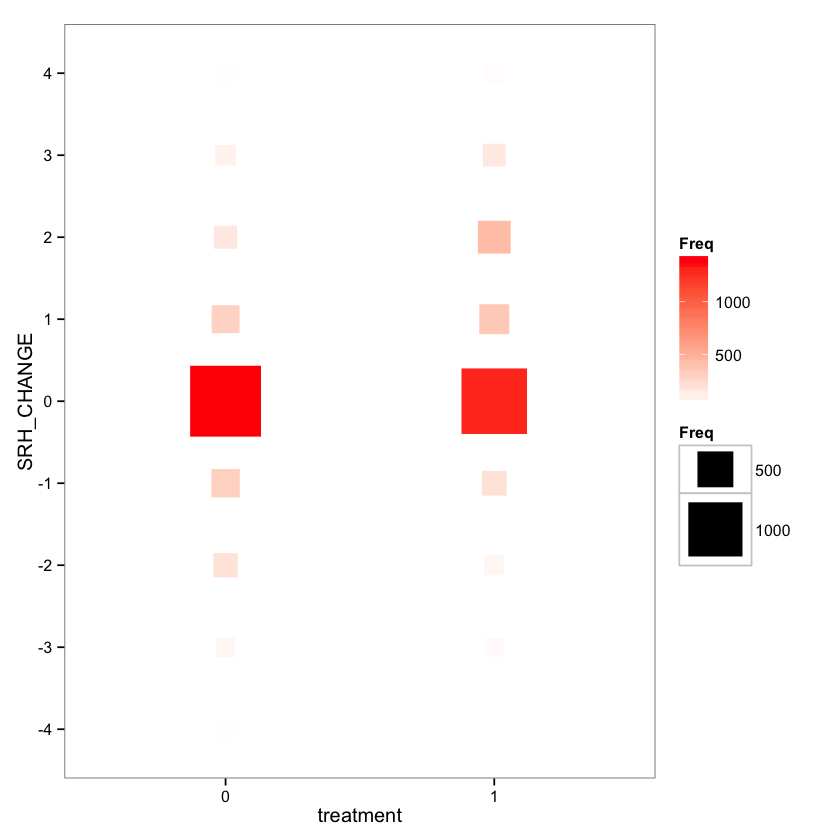

In [27]:
# visualize the relation between SRH_CHANGE and treatment/control
table_change = as.data.frame(table(data_intervention$SRH_CHANGE, data_intervention$trt))
names(table_change)[1:2] = c('SRH_CHANGE','treatment')
table_change$SRH_CHANGE = ordered(table_change$SRH_CHANGE)
ggplot(table_change, aes(treatment,SRH_CHANGE))+
   geom_point(aes(size=Freq, color =Freq, stat='identity', position='identity'),shape=15) +
   scale_size_continuous(range=c(5,20))+
   scale_color_gradient(low='white',high='red')+
   theme_nogrid()

[1] 0.09216526

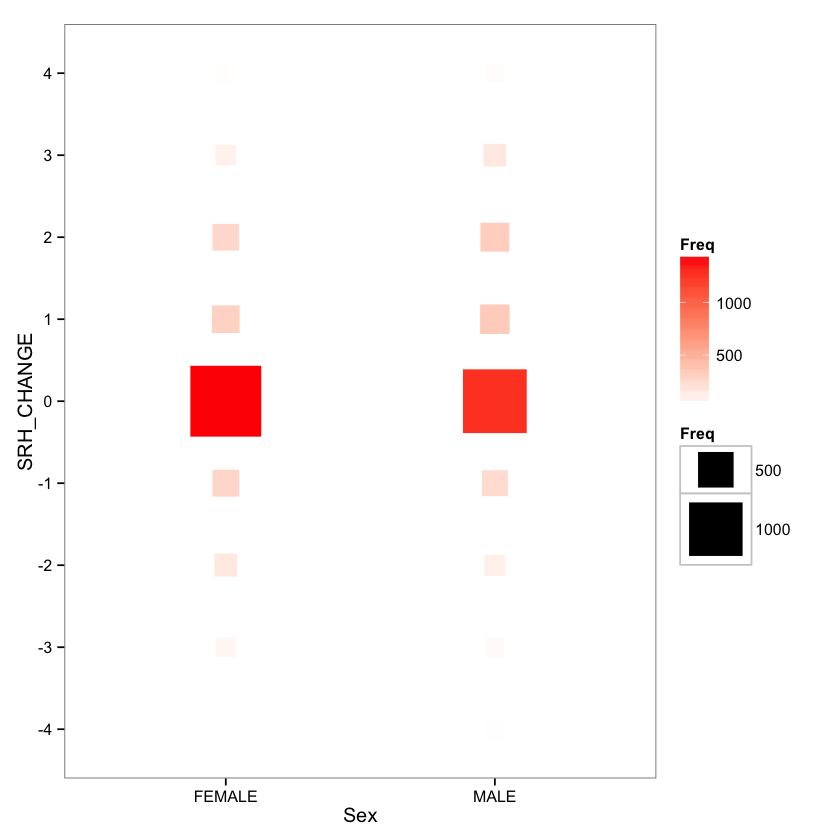

In [28]:
# Usually in logistic regression, it is not wisdom to include other non-confounding covariate in the model for covariate
# adjustment, though the covariate may highly correlated with the response; this is because covariate adjustment for 
# genearlized linear model will cause reduce in precision of the treatment effect estimate. However, here it is required
# to test if there is treatment effect - test H0: treatment effect = 0, so covariate adjustment is still prefered
# if the covariate is non-confounding and it is correlated with the response (SRH_CHANGE), which will increase the power
# of the test. 
# In our setting, the subjects have been randomized so there should be no confounding problem.
# Need to check if the baseline variable available has correlation with response, SRH_CHANGE

# visualize the relation between SRH_CHANGE and Sex
table_sex_SRH_CHANGE = as.data.frame(table(data_intervention$SRH_CHANGE, data_intervention$Sex))
names(table_sex_SRH_CHANGE)[1:2] = c('SRH_CHANGE','Sex')
ggplot(table_sex_SRH_CHANGE, aes(Sex,SRH_CHANGE))+
   geom_point(aes(size=Freq, color =Freq, stat='identity', position='identity'),shape=15) +
   scale_size_continuous(range=c(5,20))+
   scale_color_gradient(low='white',high='red')+
   theme_nogrid()
# calculate the correlation between SRH_CHANGE and Sex
cor(as.numeric(data_intervention$SRH_CHANGE),as.numeric(data_intervention$Sex))



[1] 0.00270499

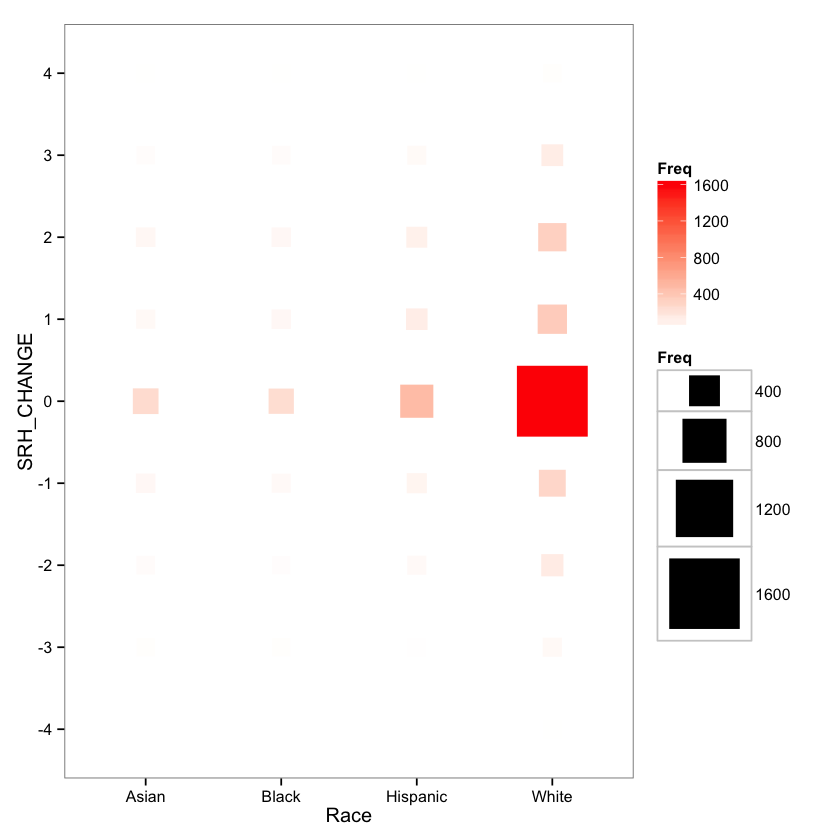

In [29]:
# visualize the relation between SRH_CHANGE and Race
table_race_SRH_CHANGE = as.data.frame(table(data_intervention$SRH_CHANGE, data_intervention$Race))
names(table_race_SRH_CHANGE)[1:2] = c('SRH_CHANGE','Race')
ggplot(table_race_SRH_CHANGE, aes(Race,SRH_CHANGE))+
   geom_point(aes(size=Freq, color =Freq, stat='identity', position='identity'),shape=15) +
   scale_size_continuous(range=c(5,20))+
   scale_color_gradient(low='white',high='red')+
   theme_nogrid()
# calculate the correlation between SRH_CHANGE and Race
# Race contain NA's so need to exclue these observations
ix.na.rm = which(!is.na(data_intervention$Race))
cor(as.numeric(data_intervention$SRH_CHANGE[ix.na.rm]),as.numeric(data_intervention$Race[ix.na.rm]))

[1] 0.01643802

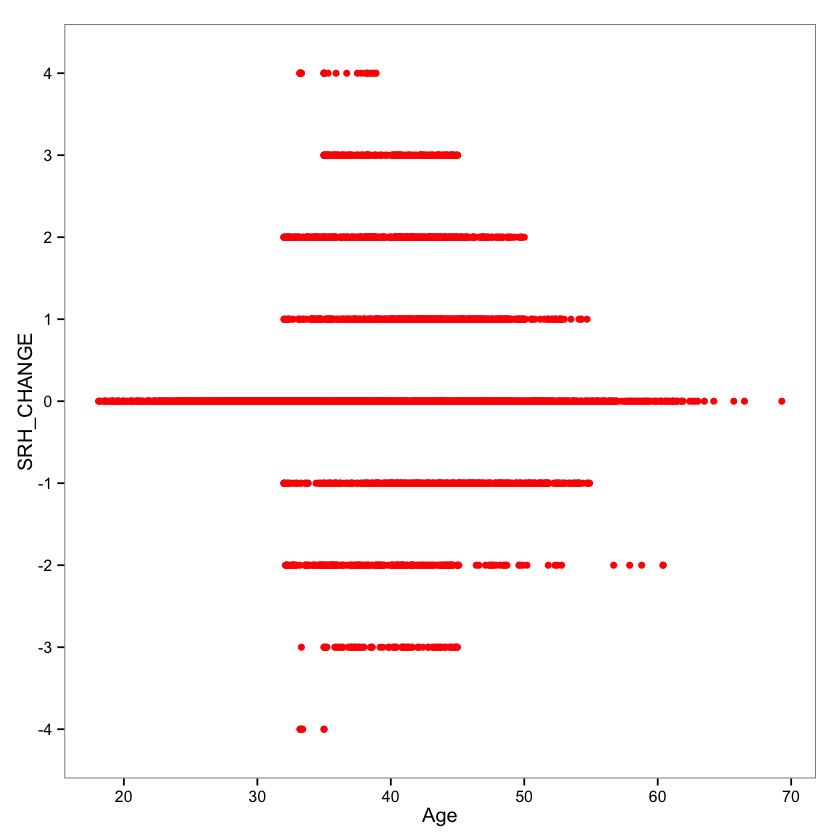

In [31]:
# visualize the relation between SRH_CHANGE and Age
ggplot() +
   geom_point(data=data_intervention, aes(Age, SRH_CHANGE), colour='red')+
   theme_nogrid()
# calculate the correlation between SRH_CHANGE and Age
cor(as.numeric(data_intervention$SRH_CHANGE),data_intervention$Age)


In [32]:
# the correlation between SRH_CHANGE and Sex/Race/Age is almost zero (shown by plot or correlation value)
# there is no need to include either of them in the model even when testing no treatment effect

# 3.1.1 testing no treatment effect H0: beta(trt) = 0
# fit two nested models
# model1: SRH_CHANGE ~ trt
# model2: SRH_CHANGE ~ 1
# test H0 by using likelihood ratios statics - the difference between the deviance of these two models

# SRH_CHANGE is ordinal variable, model Cumulative Logits/ Proportional Odds
# first model ungroup data with model1 and model2
# model1 
lm.trt.srh_change = vglm(SRH_CHANGE ~ trt, family=cumulative(parallel=TRUE), data= data_intervention)
summary(lm.trt.srh_change)


Call:
vglm(formula = SRH_CHANGE ~ trt, family = cumulative(parallel = TRUE), 
    data = data_intervention)

Pearson residuals:
                    Min       1Q   Median       3Q     Max
logit(P[Y<=1])  -0.6565 -0.03262 -0.02891 -0.02206 33.8055
logit(P[Y<=2])  -1.1202 -0.09527 -0.07603 -0.06576  9.6804
logit(P[Y<=3])  -1.0731 -0.19661 -0.13868 -0.11594  5.3183
logit(P[Y<=4])  -0.5696 -0.56955 -0.41786 -0.16138  3.5282
logit(P[Y<=5])  -2.7671 -0.50548  0.54055  0.76570  0.7657
logit(P[Y<=6])  -3.1629  0.16170  0.21717  0.30457  1.2722
logit(P[Y<=7])  -5.6885  0.10641  0.11813  0.14854  0.8610
logit(P[Y<=8]) -18.2089  0.03946  0.05338  0.05729  0.4926

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept):1 -6.24841    0.37875  -16.50   <2e-16 ***
(Intercept):2 -3.69878    0.10955  -33.76   <2e-16 ***
(Intercept):3 -2.32792    0.06103  -38.15   <2e-16 ***
(Intercept):4 -1.29587    0.04451  -29.11   <2e-16 ***
(Intercept):5  1.35182    0.04498   30.05   <2e-16

In [33]:
# model2
lm.trt.srh_change.null = vglm(SRH_CHANGE ~ 1, family=cumulative(parallel=TRUE), data= data_intervention)

summary(lm.trt.srh_change.null)



Call:
vglm(formula = SRH_CHANGE ~ 1, family = cumulative(parallel = TRUE), 
    data = data_intervention)

Pearson residuals:
                    Min       1Q   Median       3Q     Max
logit(P[Y<=1])  -0.5365 -0.02788 -0.02788 -0.02744 26.6522
logit(P[Y<=2])  -0.9608 -0.08230 -0.08230 -0.07593  7.6364
logit(P[Y<=3])  -0.9928 -0.17136 -0.17136 -0.13788  4.2266
logit(P[Y<=4])  -0.5021 -0.50214 -0.50214 -0.17672  2.8619
logit(P[Y<=5])  -2.3320 -0.43768  0.65405  0.65405  0.6541
logit(P[Y<=6])  -2.5489  0.18409  0.26471  0.26471  1.2596
logit(P[Y<=7])  -4.4921  0.13039  0.13039  0.13039  0.8094
logit(P[Y<=8]) -14.3560  0.04940  0.04940  0.05570  0.4238

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept):1 -6.56988    0.37823  -17.37   <2e-16 ***
(Intercept):2 -4.02210    0.10755  -37.40   <2e-16 ***
(Intercept):3 -2.65960    0.05720  -46.49   <2e-16 ***
(Intercept):4 -1.64195    0.03836  -42.80   <2e-16 ***
(Intercept):5  0.92372    0.03136   29.46   <2e-16 *

In [34]:
# in the above two models, each observation consumes 1 degree of freedom (corresponds to 1 parameter)
# to reduce the number of paramters, try to group data to be a contigency table

table_change = as.data.frame.matrix(table(data_intervention$trt,data_intervention$SRH_CHANGE))

names(table_change) = foreach(i=0:8)%do%(paste('change',i,sep=''))
table_change = cbind(trt=c('0','1'),table_change)
table_change

,trt,change0,change1,change2,change3,change4,change5,change6,change7,change8
0,0,6,51,178,293,1457,277,147,83,8
1,1,1,30,61,191,1311,335,414,141,16


In [56]:
# second, for the contigency table, test if there is association between treated/control and SRH_CHANGE
# model grouped data with model1 and model2

# model1
lm.trt.srh_change.group = vglm(cbind(change0,change1,change2,change3,change4,change5,change6,change7,change8)~trt, data=table_change,family=cumulative(parallel=T))
summary(lm.trt.srh_change.group)

# calculate the 95% CI for the estimate (log odds ratio)
trt1.lb.srh_change = -0.79692 - 1.96*0.05560
trt1.ub.srh_change = -0.79692 + 1.96*0.05560
ci.log = c(trt1.lb.srh_change,trt1.ub.srh_change) 

# take exponetial to get the CI for estimated odds ratios
ci = exp(ci.log)
ci
exp(-0.79692)


Call:
vglm(formula = cbind(change0, change1, change2, change3, change4, 
    change5, change6, change7, change8) ~ trt, family = cumulative(parallel = T), 
    data = table_change)

Pearson residuals:
  logit(P[Y<=1]) logit(P[Y<=2]) logit(P[Y<=3]) logit(P[Y<=4]) logit(P[Y<=5])
0         0.5684        -0.7923          1.436        -0.9711         -1.191
1        -0.8463         1.1639         -2.067         1.2440          1.081
  logit(P[Y<=6]) logit(P[Y<=7]) logit(P[Y<=8])
0          3.745         -2.011       -0.10905
1         -2.789          1.392        0.07381

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept):1 -6.24841    0.37874  -16.50   <2e-16 ***
(Intercept):2 -3.69878    0.10955  -33.76   <2e-16 ***
(Intercept):3 -2.32792    0.06103  -38.15   <2e-16 ***
(Intercept):4 -1.29587    0.04451  -29.11   <2e-16 ***
(Intercept):5  1.35182    0.04498   30.05   <2e-16 ***
(Intercept):6  2.09432    0.05119   40.92   <2e-16 ***
(Intercept):7  3.42335    

[1] 0.4041796 0.5026084

[1] 0.450715

In [36]:
# model2
lm.trt.srh_change.null.group = vglm(cbind(change0,change1,change2,change3,change4,change5,change6,change7,change8)~1, data=table_change,family=cumulative(parallel=T))
summary(lm.trt.srh_change.null.group)


Call:
vglm(formula = cbind(change0, change1, change2, change3, change4, 
    change5, change6, change7, change8) ~ 1, family = cumulative(parallel = T), 
    data = table_change)

Pearson residuals:
  logit(P[Y<=1]) logit(P[Y<=2]) logit(P[Y<=3]) logit(P[Y<=4]) logit(P[Y<=5])
0           1.19         0.5563          4.427          4.205           5.34
1          -1.19        -0.5563         -4.427         -4.205          -5.34
  logit(P[Y<=6]) logit(P[Y<=7]) logit(P[Y<=8])
0          7.346         0.8201         0.8495
1         -7.346        -0.8201        -0.8495

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept):1 -6.56988    0.37821  -17.37   <2e-16 ***
(Intercept):2 -4.02210    0.10755  -37.40   <2e-16 ***
(Intercept):3 -2.65960    0.05720  -46.49   <2e-16 ***
(Intercept):4 -1.64195    0.03836  -42.80   <2e-16 ***
(Intercept):5  0.92372    0.03136   29.46   <2e-16 ***
(Intercept):6  1.64490    0.03840   42.83   <2e-16 ***
(Intercept):7  2.95289    0.

In [37]:
# calculate likelihood ratio statistics to test H0 
(diff=deviance(lm.trt.srh_change.null.group) - deviance(lm.trt.srh_change.group) ) # likelihood ratio statistic of H0 : beta(trt) = 0
(df = df.residual(lm.trt.srh_change.null.group) - df.residual(lm.trt.srh_change.group)) # degree of freedom of the statistics(diff)
pchisq(diff,df,lower.tail=F) # p-value 

# p-value is very close to zero, then reject H0 
# the result indicates the model with treatment effect (model1) is significantly better compared to the null model
# equivalently, there is treatment effect of the intervention

[1] 211.2184

[1] 1

[1] 7.448058e-48

In [38]:
# interpret the treatment effect
# 
summary(lm.trt.srh_change.group)



Call:
vglm(formula = cbind(change0, change1, change2, change3, change4, 
    change5, change6, change7, change8) ~ trt, family = cumulative(parallel = T), 
    data = table_change)

Pearson residuals:
  logit(P[Y<=1]) logit(P[Y<=2]) logit(P[Y<=3]) logit(P[Y<=4]) logit(P[Y<=5])
0         0.5684        -0.7923          1.436        -0.9711         -1.191
1        -0.8463         1.1639         -2.067         1.2440          1.081
  logit(P[Y<=6]) logit(P[Y<=7]) logit(P[Y<=8])
0          3.745         -2.011       -0.10905
1         -2.789          1.392        0.07381

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept):1 -6.24841    0.37874  -16.50   <2e-16 ***
(Intercept):2 -3.69878    0.10955  -33.76   <2e-16 ***
(Intercept):3 -2.32792    0.06103  -38.15   <2e-16 ***
(Intercept):4 -1.29587    0.04451  -29.11   <2e-16 ***
(Intercept):5  1.35182    0.04498   30.05   <2e-16 ***
(Intercept):6  2.09432    0.05119   40.92   <2e-16 ***
(Intercept):7  3.42335    

In [39]:
# step 3.2 explore the invention effect on WEIGHT_CHANGE

# create a new variable 'weight_change' defined as
# WEIGHT_CHANGE = POST_WEIGHT - PRE_WEIGHT

data_intervention$WEIGHT_CHANGE = data_intervention$POST_WEIGHT - data_intervention$PRE_WEIGHT


[1] -0.009333406

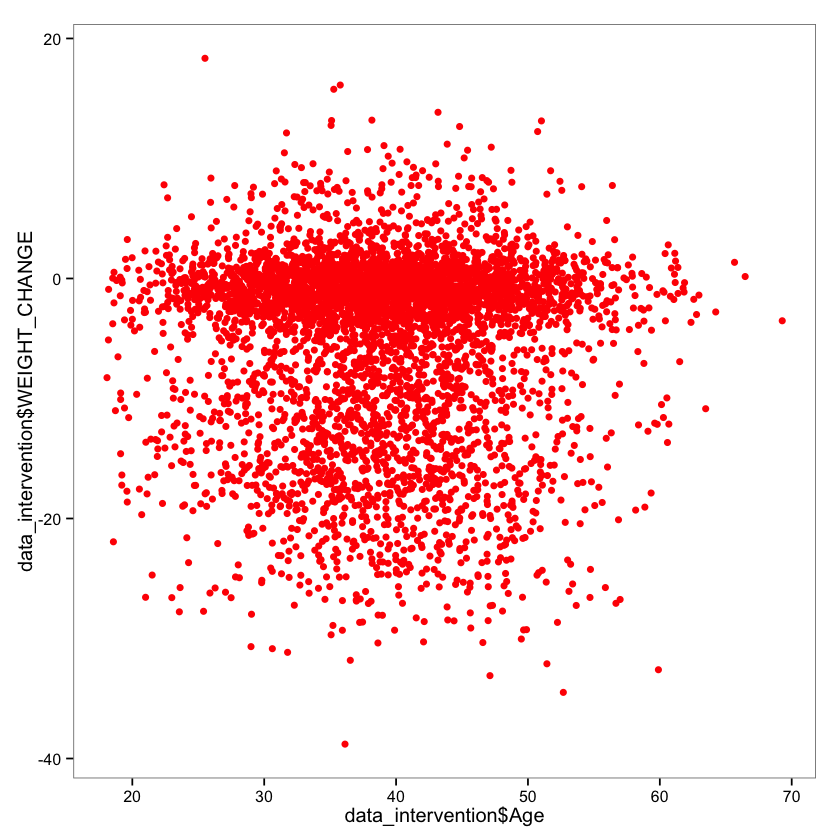

In [40]:
# explore the relation between WEIGHT_CHANGE and AGE
ggplot(data_intervention, aes(data_intervention$Age, data_intervention$WEIGHT_CHANGE))+
   geom_jitter(color = 'red')+
   theme_nogrid()
# no correlation indicated in the scatterplot and cor()
cor(data_intervention$Age,data_intervention$WEIGHT_CHANGE)

[1] -0.4879073

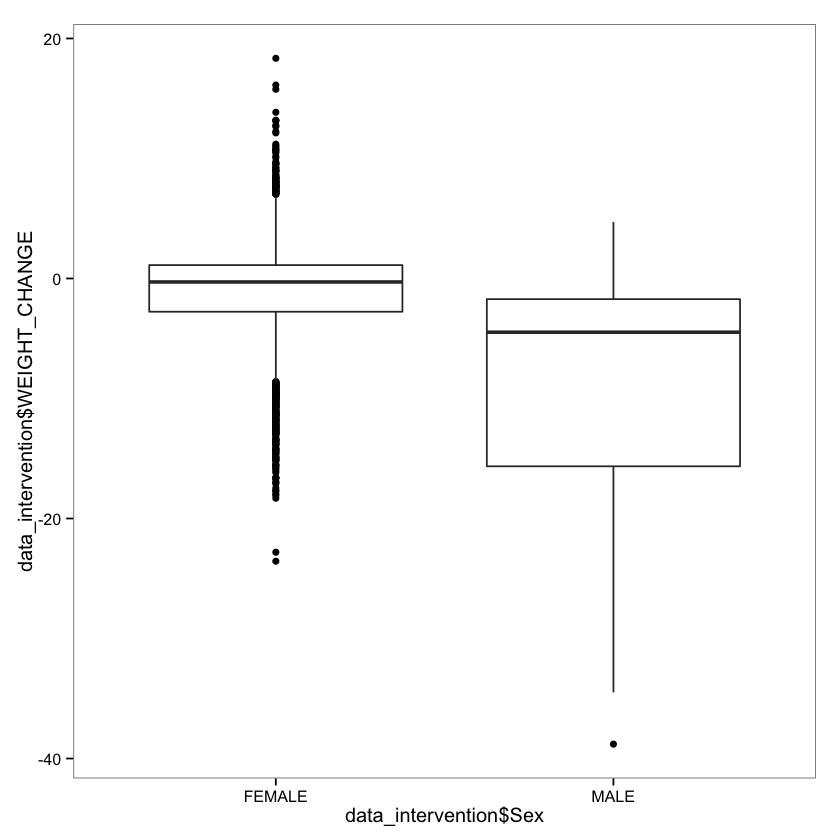

In [41]:
# explore the relation between WEIGHT_CHANGE and AGE
ggplot(data_intervention, aes(data_intervention$Sex, data_intervention$WEIGHT_CHANGE))+
   geom_boxplot()+
   theme_nogrid()
cor(as.numeric(data_intervention$Sex),data_intervention$WEIGHT_CHANGE)
# weight change differ between female and male as indicated by the boxplot and the correlation 
# could include Sex for covariate adjustment to increase precision of estimate

[1] -0.001737055

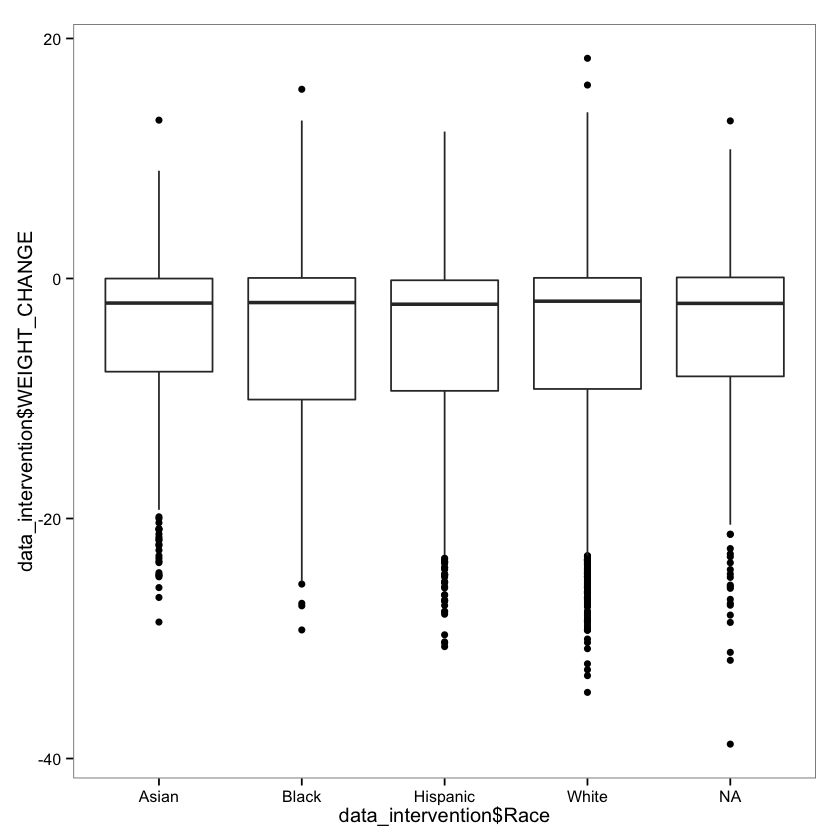

In [42]:
# explore the relation between WEIGHT_CHANGE and Race
ggplot(data_intervention, aes(data_intervention$Race, data_intervention$WEIGHT_CHANGE))+
   geom_boxplot()+
   theme_nogrid()
# ix.na.rm: indicator vector for non-na obervations of Race got in previous step
cor(as.numeric(data_intervention$Race[ix.na.rm]),data_intervention$WEIGHT_CHANGE[ix.na.rm])
# no difference of WEIGHT_CHANGE across different groups of Race shown in boxplot and correlation

In [43]:
# to test analyze the intervention effect in terms of 'WEIGHT_CHANGE' try three linear regression models

# model1' (lm.trt.weight): WEIGHT_CHANGE ~ trt 
# model2' (lm.trt.weight.adj): WEIGHT_CHANGE ~ trt + Sex
# model3' (lm.trt.weight.adj.null): WEIGHT_CHANGE ~ Sex

# first test no treatment effect H0: Beta(trt) = 0
# compare model2' and model3 using anova

# model2'
lm.trt.weight.adj = lm(WEIGHT_CHANGE ~ trt + Sex, data= data_intervention)
summary(lm.trt.weight.adj)



Call:
lm(formula = WEIGHT_CHANGE ~ trt + Sex, data = data_intervention)

Residuals:
     Min       1Q   Median       3Q      Max 
-26.0287  -3.1832  -0.1733   3.2096  23.7048 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.8310     0.1279   22.13   <2e-16 ***
trt1         -8.1878     0.1491  -54.92   <2e-16 ***
SexMALE      -7.4156     0.1491  -49.73   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.271 on 4997 degrees of freedom
Multiple R-squared:  0.5248,	Adjusted R-squared:  0.5247 
F-statistic:  2760 on 2 and 4997 DF,  p-value: < 2.2e-16


In [45]:
# model3'
lm.trt.weight.adj.null = lm(WEIGHT_CHANGE ~ Sex, data = data_intervention)
summary(lm.trt.weight.adj.null)


Call:
lm(formula = WEIGHT_CHANGE ~ Sex, data = data_intervention)

Residuals:
    Min      1Q  Median      3Q     Max 
-30.099  -4.129   1.216   5.454  19.588 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.2405     0.1320  -9.397   <2e-16 ***
SexMALE      -7.4615     0.1888 -39.516   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.674 on 4998 degrees of freedom
Multiple R-squared:  0.2381,	Adjusted R-squared:  0.2379 
F-statistic:  1562 on 1 and 4998 DF,  p-value: < 2.2e-16


In [47]:
# compare goodness of fit of model2' and model3' by chi-square statistics
anova(lm.trt.weight.adj,lm.trt.weight.adj.null,test="Chisq")
# the p-value is zero, reject H0: Beta(trt) = 0
# it indicates that model2' is significantly better than model3' and there is treatment effect of the intervention in terms of change in weight

# estimated treatment effect is -8.1878 with standard error 0.1491 
# an increase in precision of the estimate after adjustment

,Res.Df,RSS,Df,Sum of Sq,Pr(>Chi)
1,4997,138836.8,NA,NA,NA
2,4998,222634.9,-1,-83798.08,0


In [48]:
# model1'
lm.trt.weight = lm(WEIGHT_CHANGE ~ trt, data= data_intervention)
summary(lm.trt.weight)


Call:
lm(formula = WEIGHT_CHANGE ~ trt, data = data_intervention)

Residuals:
     Min       1Q   Median       3Q      Max 
-29.7988  -2.2746  -0.0187   2.2404  27.3503 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.7730     0.1289  -5.998 2.14e-09 ***
trt1         -8.2294     0.1823 -45.151  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.444 on 4998 degrees of freedom
Multiple R-squared:  0.2897,	Adjusted R-squared:  0.2896 
F-statistic:  2039 on 1 and 4998 DF,  p-value: < 2.2e-16


[1] -8.529153 -8.229358 -7.929563

[1] -8.433062 -8.187830 -7.942598

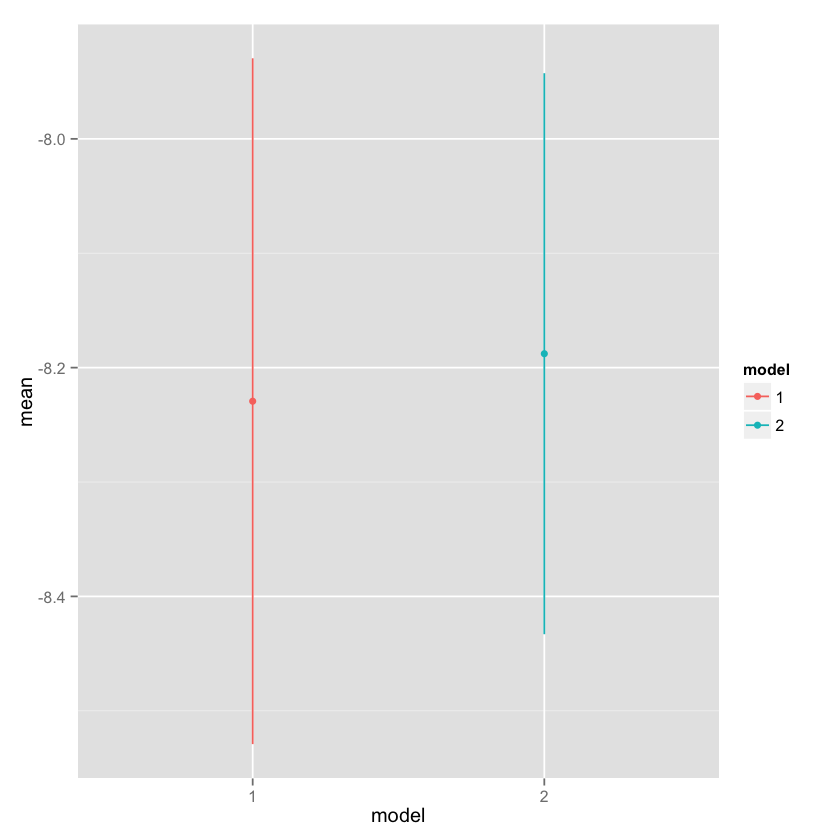

In [50]:
# second compare the results of model1' and model2' to see an increase in precision of treatment effect estimate after covariate adjustment

# visualize the two estimates and the corresponding confience interval
# CI: function for returning 95% confidence interval of estimated effect of intervention

# get the estimate and CI for model1' lm.trt.weight
lm.trt.weight.ci = CI(lm.trt.weight)
lm.trt.weight.ci

# get the estimate and CI for model lm.trt.weight.adj
lm.trt.weight.adj.ci = CI(lm.trt.weight.adj)
lm.trt.weight.adj.ci

# visualize the estimated treatment and confidence interval
est.ci = as.data.frame(rbind(lm.trt.weight.ci,lm.trt.weight.adj.ci))
names(est.ci)=c('min','mean','max')

est.ci$model = as.factor(c(1,2))


ggplot(est.ci, aes(model,y=mean,ymin=min,ymax=max,color=model))+
   geom_pointrange()

# the plot clearly shows a reduced confidence interval 


In [55]:
# QUESTION 4: Explain the results to the investigator. Please assume the investigator has limited 
# statistical knowledge. Tell her whether there is or is not a treatment effect and if so, how the
# two groups differ with respect to their weight profiles and SRH over time.

# In terms of intervention's effect on change in weight (WEIGHT_CHANGE) = POST_WEIGHT - PRE_WEIGHT
# The treated group has averagely 8.19 more loss in weight after intervention compared with the control group.
# There exists treatment effect of the intervention on change in weight
# The significance of the effect can be shown
# 1) the 95% confidence interval does not cover zero; and the p-value of wald statistics is much smaller than 0.05
# 2) anova result shows the model with treatment effect is significantly better than the null model

# 95% WALD CI is [-8.43, -7.94] indicating there is 95% probability that this interval covers the true treatment effect
# The group with intervention can have averagely at most 8.43 more and at least 7.94 more loss in weight after the intervention compared to the group without intervention 
lm.trt.weight.adj.ci

# In terms of intervention's effect on change in self-report health SRH_CHANGE = POST_SRH - PRE_SRH
# 95 WALD confidence interval of estimated odds ratio is [0.404, 0.502] indicating that there is 95 probability 
# that this interval will cover the true odds ratio in repeated sampling;
# the estimated odds ratio is 0.451, which means averagely the odds of feeling better for health given intervention is
# 1/0.451 times the odds without intervention
# Given the interval covers the true odds ratio, the odds of feeling better for health given intervention could be
# as small as 1/0.502 times and as large as 1/0.404 times the odds without intervention
# There exists treatment effect of the intervention on change in SRH
# The significance of the effect can be shown
# 1) the 95% WALD ci does not cover zero showing a significant positive association between feeling better for health
#    and intervention
# 2) the likelihood ratio statistics shows that the model with treatment effect is significantly better than the reduced
#    model
ci

[1] -8.433062 -8.187830 -7.942598

[1] 0.4041796 0.5026084

In [ ]:
# QUESTION 6: What if the two groups (treatment and control) were not randomized? How might
# you evaluate the intervention now? What additional information might you require, and which 
# methods could you use? What would be your limitations

# if not randomized, then the two groups could be systemetically differently. Even conditioning on baseline variables,
# the difference between the mean of the responses of two groups will be a biased estimate of intervention effect; baselind
# variables in this case could be confounding with the intervention effect. 
# Intervention can be evaluated using matched pairs. Matched subjects should differ only in assignment of group.
# In order to march observation, it is necessary to have all covariates that could confound with the assignment of group. 
# In the case when there are just a few confounded variables, it is possible to do exact matching
# But if there are many variables, then it is helpful to do propensity score matching.
# The limitations 
# 1) inbalance of some covariate within subgroup after matching 
# 2) lack of overlapping of propensity score between treated and control group 
# 3) a waste of those unmatched observations (exact matching)